In [1]:
# default_exp tensorrt_inference_py

This is really just for command-line testing/profiling purposes. Call this like:
    
`nvprof python test_fast_inference/tensorrt_inference_py.py <path to model.engine> <path to X.raw>`

In order to profile it and check if tensor core instructions are being used. As the name suggests, this performs inference with tensorrt using the python API.

In [2]:
# export
import pycuda.autoinit
import pycuda.driver as cuda

import fire
import torch
import numpy as np
import tensorrt as trt
import matplotlib.pyplot as plt

In [3]:
# export
trt.init_libnvinfer_plugins(None, '') # This will load additional plugins (like instance norm layer)

True

In [4]:
# export
def tensorrt_inference(file_engine, file_batch, plot=False):
    # Load engine
    runtime = trt.Runtime(trt.Logger(trt.Logger.VERBOSE))
    with open(file_engine, 'rb') as f:
        engine = runtime.deserialize_cuda_engine(f.read())
    context = engine.create_execution_context()    
    
    # Allocate buffers
    X_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
    y_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
    X_d = cuda.mem_alloc(X_h.nbytes)
    y_d = cuda.mem_alloc(y_h.nbytes)
    
    # Read batch - assumes this is stored as float and already pre-processed
    with open(file_batch, 'rb') as f:
        f.readinto(X_h)

    # Inference
    stream = cuda.Stream()
    cuda.memcpy_htod_async(X_d, X_h, stream)
    context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle)
    cuda.memcpy_dtoh_async(y_h, y_d, stream)
    stream.synchronize()
    y_h = y_h.reshape(engine.get_binding_shape(1))
    y = torch.from_numpy(y_h).argmax(dim=1).squeeze(axis=0)
    
    if plot:
        plt.imshow(y, vmin=0, vmax=4)
        plt.show()
    
    return y

In [5]:
file_engine = 'training/attempt_2/model_8.engine'
file_batch  = 'batches_trn/X0.raw'
y = tensorrt_inference(file_engine, file_batch)

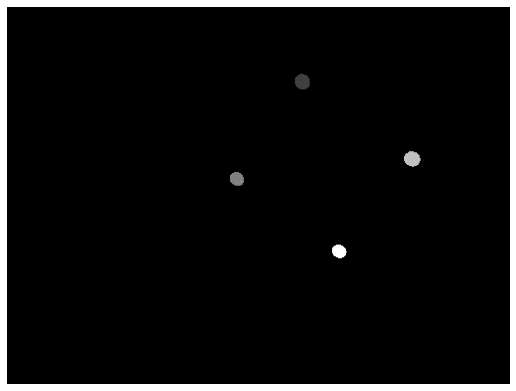

In [6]:
plt.figure(figsize=(9, 9))
plt.imshow(y, vmin=0, vmax=4, cmap='gray')
plt.axis('off');

In [ ]:
# export
if __name__ == '__main__':
    fire.Fire(tensorrt_inference)

# Build

In [7]:
!nbdev_build_lib --fname tensorrt_inference_py.ipynb

Converted tensorrt_inference_py.ipynb.
